In [5]:
# Import relevant modules
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use('dark_background')
import seaborn as sns
from netCDF4 import Dataset, date2num
import datetime as dt
import time

In [2]:
#OPeNDAP link to data
url = 'https://data.cci.ceda.ac.uk/thredds/dodsC/esacci.OC.mon.L3S.CHLOR_A.multi-sensor.multi-platform.MERGED.5-0.geographic?lat[0:1:4319],lon[0:1:8639],chlor_a[0:1:279][0:1:4319][0:1:8639],time[0:1:279]'
# Read data 
data = Dataset(url)

In [3]:
# Time metadata
data.variables['time']

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    standard_name: time
    units: days since 1970-01-01 00:00:00
    axis: T
    _ChunkSizes: 1
unlimited dimensions: 
current shape = (280,)
filling off

In [4]:
# Chlorophyll-a metadata
data.variables['chlor_a']

<class 'netCDF4._netCDF4.Variable'>
float32 chlor_a(time, lat, lon)
    _FillValue: 9.96921e+36
    long_name: Chlorophyll-a concentration in seawater (not log-transformed), generated by as a blended combination of OCI, OCI2, OC2 and OCx algorithms, depending on water class memberships
    units: milligram m-3
    ancillary_variables: chlor_a_log10_rmsd chlor_a_log10_bias
    grid_mapping: crs
    parameter_vocab_uri: http://vocab.ndg.nerc.ac.uk/term/P011/current/CHLTVOLU
    standard_name: mass_concentration_of_chlorophyll_a_in_sea_water
    units_nonstandard: mg m^-3
    _ChunkSizes: [  1 270 270]
unlimited dimensions: 
current shape = (280, 4320, 8640)
filling off

In [5]:
# Get time values
times = np.ma.getdata(data.variables['time'][:])
# Check first time value
time = times[0]
start = dt.date(1970,1,1)
time_diff = float(time)
new_time = start + dt.timedelta(days=time_diff)
print(new_time)

datetime.date(1997, 9, 4)

In [6]:
# Get latitudes
lats_ma = data.variables['lat'][:] # Get data
lats = np.ma.getdata(lats_ma) # Remove mask
# Get longitudes 
lons_ma = data.variables['lon'][:] # Get data
lons = np.ma.getdata(lons_ma) # Remove mask

In [7]:
# Shape of chlorophyll-a data
data.variables['chlor_a'].shape

(280, 4320, 8640)

In [8]:
# Get chlorophyll-a data for first time value
chl_ma = data.variables['chlor_a'][0,:,:] # Get data
chl = np.ma.getdata(chl_ma) # Remove mask
print(chl)

array([[9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
        9.96921e+36, 9.96921e+36],
       [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
        9.96921e+36, 9.96921e+36],
       [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
        9.96921e+36, 9.96921e+36],
       ...,
       [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
        9.96921e+36, 9.96921e+36],
       [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
        9.96921e+36, 9.96921e+36],
       [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
        9.96921e+36, 9.96921e+36]], dtype=float32)

In [9]:
# Change filled values to NaN
chl[chl>9e+36] = np.nan
print(chl) # Print to check

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

<AxesSubplot:>

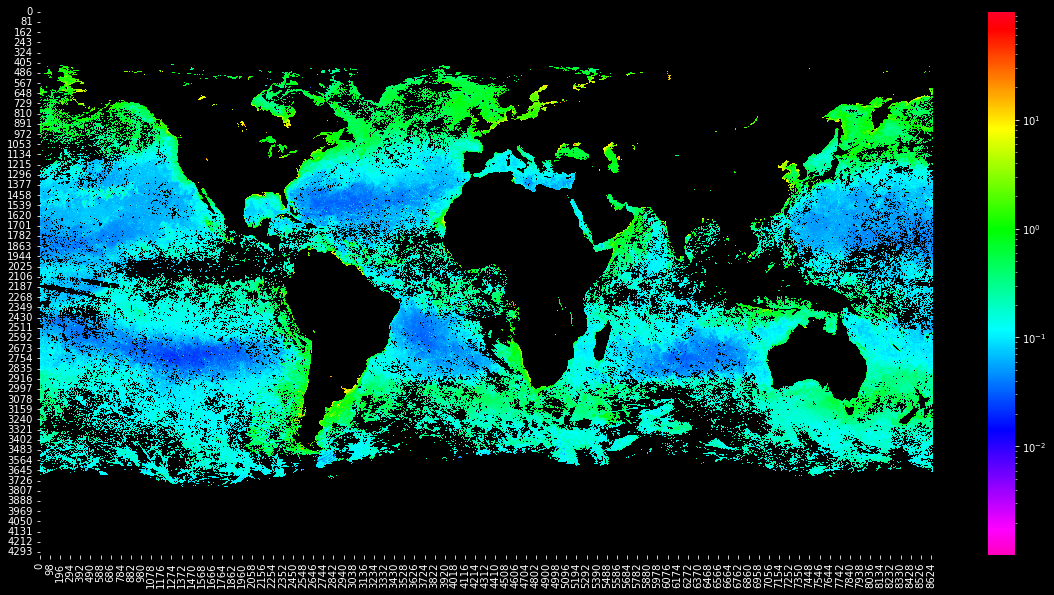

In [10]:
# Print heatmap of data
plt.figure(figsize=(20,10))
sns.heatmap(chl, norm=LogNorm(), cmap='gist_rainbow_r')

In [15]:
### LOOP TO ACQUIRE AND AVERAGE DATA ###

start_date = dt.date(1970, 1, 1) # Set start date
start_num = 0 # Set start time index - can be changed for different start date

# Loop over data indexes
for i in range(start_num,data.variables['chlor_a'].shape[0],1):
    
    start_time = time.time() # Start timer to check rate of loop
    
    chl = np.ma.getdata(data.variables['chlor_a'][i,:,:]) # Get chlorophyll-a values for one index

    chl[chl > 9e+36] = np.nan # Make values less than zero equal to NaN so they don't affect the mean

    # One month of data in Dataframe
    one_month_data = pd.DataFrame(data=chl, index=lats, columns=lons)

    # Initialise a 1x1 degree grid of zeros
    one_deg_grid = np.zeros((len(range(90,-90,-1)),len(range(-180,180,1))))

    # Loop over latitudes - increments of 1-degree
    for lat_ind,latitude in enumerate(range(90,-90,-1)):
        # Loop over longitudes - increments of 1-degree
        for lon_ind,longitude in enumerate(range(-180,180,1)):
            
            # Get 1x1 degree square of values 
            # (Different if/elif statements catch the values on the grid to ensure no data is missed)
            if (longitude == 179) and (latitude == -89):
                one_deg_square = np.asarray(one_month_data.loc[(one_month_data.index <= latitude) & (one_month_data.index >= latitude-1),(one_month_data.columns >= longitude) & (one_month_data.columns <= longitude+1)])
            
            elif (longitude == 179):
                one_deg_square = np.asarray(one_month_data.loc[(one_month_data.index <= latitude) & (one_month_data.index > latitude-1),(one_month_data.columns >= longitude) & (one_month_data.columns <= longitude+1)])
                
            elif (latitude == -89):
                one_deg_square = np.asarray(one_month_data.loc[(one_month_data.index <= latitude) & (one_month_data.index >= latitude-1),(one_month_data.columns >= longitude) & (one_month_data.columns < longitude+1)])
                
            else:
                one_deg_square = np.asarray(one_month_data.loc[(one_month_data.index <= latitude) & (one_month_data.index > latitude-1),(one_month_data.columns >= longitude) & (one_month_data.columns < longitude+1)])

            # If all values in square are NaN, set the square mean and NaN
            if np.isnan(one_deg_square).all() == True:
                one_deg_mean = np.nan
            # Else set to the mean of the values in the square (excluding NaNs)
            else:
                one_deg_mean = np.nanmean(one_deg_square)

            # Append chl-a mean to grid
            one_deg_grid[lat_ind, lon_ind] = one_deg_mean
            
    
    # Create or stack 3d array of one degree grids
    if i == start_num:
        chl_grid_data = one_deg_grid
    else:
        chl_grid_data = np.dstack((chl_grid_data, one_deg_grid))
    
    # Update time (for reference purposes)
    time_diff = float(np.ma.getdata(data.variables['time'])[i])
    current_time = start_date + dt.timedelta(days=time_diff)
    
    end_time = time.time() # End timer of loop
    
    # Print date of data so that completion is known, and time taken for loop
    print(current_time, round(end_time-start_time,3)) 

1997-09-04 144.336
1997-10-01 149.909
1997-11-01 134.318
1997-12-01 148.222
1998-01-01 168.428
1998-02-01 130.473
1998-03-01 137.556
1998-04-01 151.711
1998-05-01 136.572
1998-06-01 146.807
1998-07-01 155.572
1998-08-01 132.428
1998-09-01 131.601
1998-10-01 160.312
1998-11-01 156.473
1998-12-01 171.668
1999-01-01 150.758
1999-02-01 135.642
1999-03-01 145.222
1999-04-01 129.155
1999-05-01 125.073
1999-06-01 150.685
1999-07-01 137.265
1999-08-01 144.209
1999-09-01 148.711
1999-10-01 173.767
1999-11-01 146.572
1999-12-01 168.29
2000-01-01 153.279
2000-02-01 139.141
2000-03-01 141.862
2000-04-01 125.117


Error:curl error: Stream error in the HTTP/2 framing layer
Error:DAP DATADDS packet is apparently too short


2000-05-01 280.526
2000-06-01 152.064
2000-07-01 118.214
2000-08-01 124.812
2000-09-01 121.251
2000-10-01 126.834
2000-11-01 122.154
2000-12-01 145.534
2001-01-01 138.595
2001-02-01 121.59
2001-03-01 129.379
2001-04-01 118.456
2001-05-01 126.817
2001-06-01 120.647
2001-07-01 124.715
2001-08-01 122.069
2001-09-01 120.132
2001-10-01 127.063
2001-11-01 144.954
2001-12-01 138.359
2002-01-01 134.75
2002-02-01 146.834
2002-03-01 146.339
2002-04-01 129.097
2002-05-01 137.872
2002-06-01 121.141
2002-07-01 115.745
2002-08-01 114.814
2002-09-01 115.222
2002-10-01 122.981
2002-11-01 115.443
2002-12-01 113.941
2003-01-01 106.927
2003-02-01 113.277
2003-03-01 126.143
2003-04-01 114.126
2003-05-01 120.362
2003-06-01 118.429
2003-07-01 137.141
2003-08-01 124.159
2003-09-01 125.866
2003-10-01 121.558
2003-11-01 126.152
2003-12-01 128.989
2004-01-01 139.181
2004-02-01 127.902
2004-03-01 144.328
2004-04-01 146.407
2004-05-01 148.839
2004-06-01 125.265
2004-07-01 125.698
2004-08-01 114.63
2004-09-01 122.

In [16]:
# Print new data shape
chl_grid_data.shape

(180, 360, 280)

<AxesSubplot:>

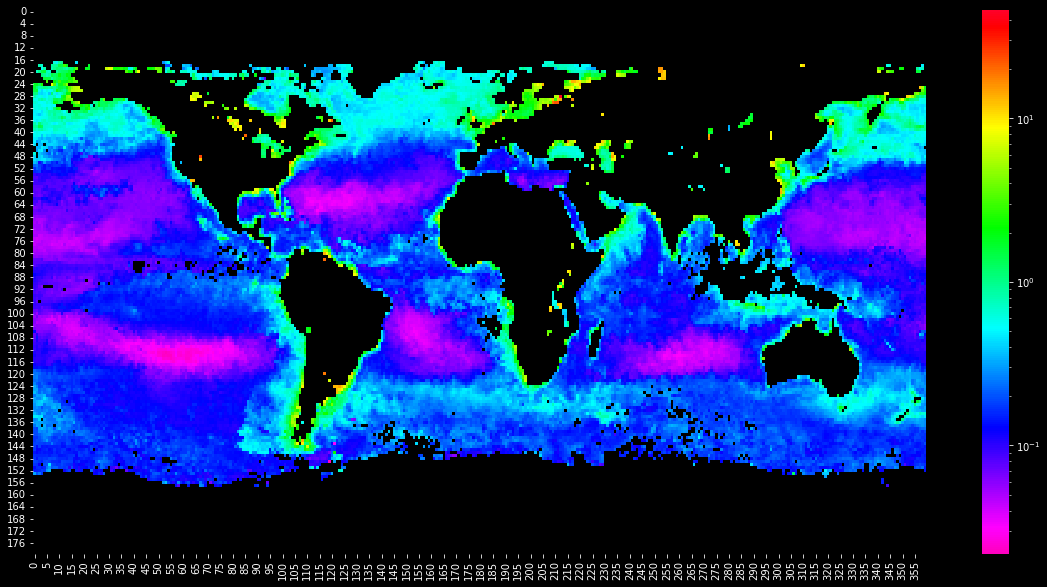

In [18]:
# Plot data of first time index
plt.figure(figsize=(20,10))
sns.heatmap(chl_grid_data[:,:,0], norm=LogNorm(), cmap='gist_rainbow_r')

In [19]:
# Flatten data for export to csv
for i in range(0, chl_grid_data.shape[2]):
    if i == 0:
        chl_flat = chl_grid_data[:,:,i]
    else:
        chl_slice = chl_grid_data[:,:,i]
        chl_flat = np.concatenate((chl_flat,chl_slice), axis=0)

# Flat data shape
print(chl_flat.shape)

In [21]:
np.savetxt('chl_grid_DATA_ONLY.csv', chl_flat, delimiter=',')

#### Edit 01-05-2000 ####
The data for 1/5/2000 incurred some error. The data was still averaged, but to ensure correctness, the data will be recalculated

In [14]:
# Import csv data
chl_LR_data = np.loadtxt('chl_grid_DATA_ONLY.csv', delimiter=',')
print(chl_LR_data.shape)

(50400, 360)

In [15]:
# Loop used to re-stack the data intoo 3D-array
for r in range(0,chl_LR_data.shape[0],180):
    if r==0:
        chl_stack = chl_LR_data[r:r+180,:]
    else:
        chl_stack = np.dstack((chl_stack,chl_LR_data[r:r+180,:]))
# Print array shape
print(chl_stack.shape)

(180, 360, 280)


In [5]:
# Function to get difference in months to find correct index
def month_diff(dt1, dt2):
    return 12 * (dt1.year - dt2.year) + (dt1.month - dt2.month)

In [30]:
# Start date of data
start_date = dt.date(1997,9,4)
print(start_date)
# Target date
end_date = dt.date(2000,5,1)
print(end_date)

1997-09-04
2000-05-01


In [31]:
# Find diffence in months
month_diff(end_date, start_date)

32

In [3]:
# Get 01/05/2000 data and read it
url = 'https://data.cci.ceda.ac.uk/thredds/dodsC/esacci.OC.mon.L3S.CHLOR_A.multi-sensor.multi-platform.MERGED.5-0.geographic?lat[0:1:4319],lon[0:1:8639],chlor_a[32:1:32][0:1:4319][0:1:8639],time[32:1:32]'
data = Dataset('ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-200005-fv5.0.nc')

In [4]:
# Check time meta data
data['time']

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    axis: T
    standard_name: time
    units: days since 1970-01-01 00:00:00
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of -2147483647 used

In [5]:
# Check chorophyll metadata
data['chlor_a']

<class 'netCDF4._netCDF4.Variable'>
float32 chlor_a(time, lat, lon)
    _FillValue: 9.96921e+36
    long_name: Chlorophyll-a concentration in seawater (not log-transformed), generated by as a blended combination of OCI, OCI2, OC2 and OCx algorithms, depending on water class memberships
    units: milligram m-3
    ancillary_variables: chlor_a_log10_rmsd chlor_a_log10_bias
    grid_mapping: crs
    parameter_vocab_uri: http://vocab.ndg.nerc.ac.uk/term/P011/current/CHLTVOLU
    standard_name: mass_concentration_of_chlorophyll_a_in_sea_water
    units_nonstandard: mg m^-3
unlimited dimensions: 
current shape = (1, 4320, 8640)
filling on

In [6]:
# Check index date corresponds to 01/05/2000
start_date = dt.date(1970,1,1)
t_diff = np.ma.getdata(data['time'][:])[0]
check_date = start_date + dt.timedelta(days=float(t_diff))
print(check_date)

2000-05-01


In [7]:
# Get latitude values and remove mask
lats_ma = data.variables['lat'][:]
lats = np.ma.getdata(lats_ma)
# Get longitude values and remove mask
lons_ma = data.variables['lon'][:]
lons = np.ma.getdata(lons_ma)

In [11]:
# Get chlorophyll data
chl = np.ma.getdata(data['chlor_a'])[0,:,:]
# Set values less than zero equal to NaN so they don't affect the mean
chl[chl > 9e+36] = np.nan

# One month of data in Dataframe
one_month_data = pd.DataFrame(data=chl, index=lats, columns=lons)

# Initialise a 1x1 degree grid of zeros
one_deg_grid = np.zeros((len(range(90,-90,-1)),len(range(-180,180,1))))

# Loop over latitudes - increments of 1-degree
for lat_ind,latitude in enumerate(range(90,-90,-1)):
    # Loop over longitudes - increments of 1-degree
    for lon_ind,longitude in enumerate(range(-180,180,1)):

        # Get 1x1 degree square of values 
        # (Different if/elif statements catch the values on the grid to ensure no data is missed)        
        if (longitude == 179) and (latitude == -89):
            one_deg_square = np.asarray(one_month_data.loc[(one_month_data.index <= latitude) & (one_month_data.index >= latitude-1),(one_month_data.columns >= longitude) & (one_month_data.columns <= longitude+1)])

        elif (longitude == 179):
            one_deg_square = np.asarray(one_month_data.loc[(one_month_data.index <= latitude) & (one_month_data.index > latitude-1),(one_month_data.columns >= longitude) & (one_month_data.columns <= longitude+1)])

        elif (latitude == -89):
            one_deg_square = np.asarray(one_month_data.loc[(one_month_data.index <= latitude) & (one_month_data.index >= latitude-1),(one_month_data.columns >= longitude) & (one_month_data.columns < longitude+1)])

        else:
            one_deg_square = np.asarray(one_month_data.loc[(one_month_data.index <= latitude) & (one_month_data.index > latitude-1),(one_month_data.columns >= longitude) & (one_month_data.columns < longitude+1)])

        # If all values in square are NaN, set the square mean and NaN
        if np.isnan(one_deg_square).all() == True:
            one_deg_mean = np.nan
        # Else set to the mean of the values in the square (excluding NaNs)
        else:
            one_deg_mean = np.nanmean(one_deg_square)

        # Append chl-a mean to grid
        one_deg_grid[lat_ind, lon_ind] = one_deg_mean

# Assign unique variable to hold data
chl_2000_05_data = one_deg_grid

<AxesSubplot:>

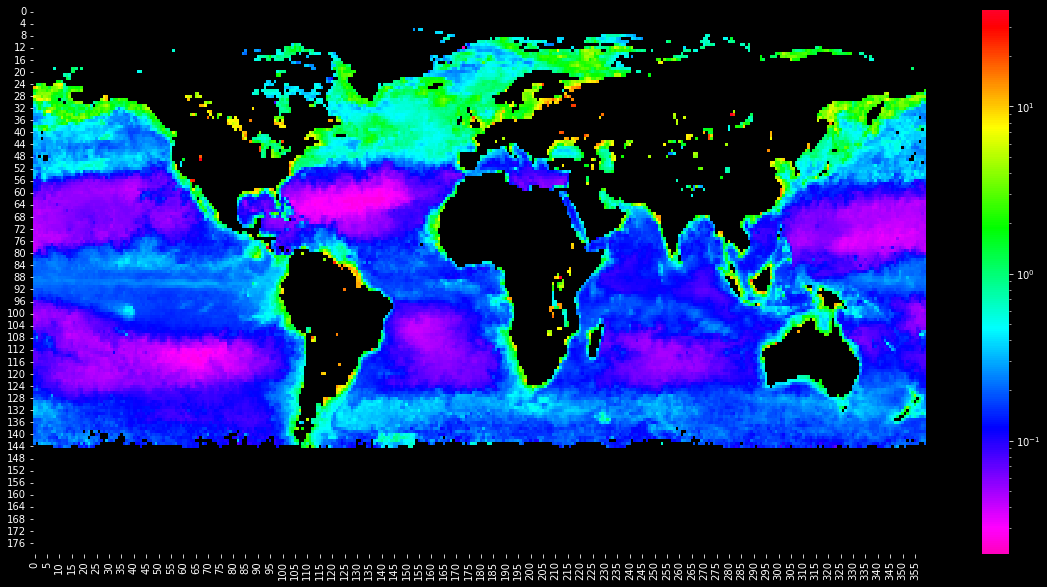

In [13]:
# Check 01/05/2000 plot
plt.figure(figsize=(20,10))
sns.heatmap(chl_2000_05_data, norm=LogNorm(), cmap='gist_rainbow_r')

In [23]:
# Replace data in orginal data array with new data
chl_stack[:,:,32] = chl_2000_05_data

In [24]:
# Flatten data
for i in range(0, chl_stack.shape[2]):
    if i == 0:
        chl_flat = chl_stack[:,:,i]
    else:
        chl_slice = chl_stack[:,:,i]
        chl_flat = np.concatenate((chl_flat,chl_slice), axis=0)
        
# Check data shape
print(chl_flat.shape)

In [25]:
# Save new data set
np.savetxt('chl_LR_data.csv', chl_flat, delimiter=',')

### ADD CLIMATOLOGY ###
Data is not available for 01/1990 - 08/1997 and so climatology means must be used to fill data for use in Global Carbon Project

In [26]:
# Load previously produced data
chl_data = np.loadtxt('chl_LR_data.csv', delimiter=',')

# Convert flat data intp 3D-array
for r in range(0,chl_data.shape[0],180):
    if r==0:
        chl_stack = chl_data[r:r+180,:]
    else:
        chl_stack = np.dstack((chl_stack,chl_data[r:r+180,:]))

print(chl_stack.shape)

In [63]:
### PAST FILL ### -> average data from first N years

# Get number of months (indexes) covering the first N=15 years of data
num_idxs = 15 * 12 

# Loop over data in increments of 12 to get data from th same months
for d in range(0,12):
    
    # Get data and find the mean over 15 years
    month_climatology = np.nanmean(chl_stack[:,:,d:num_idxs:12],axis=2)
    
    # Create/combine data into 3D-array
    if d == 0:
        past_climatology = month_climatology
    else:
        past_climatology = np.dstack((past_climatology,month_climatology))

/Users/joshblannin/opt/anaconda3/envs/python_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [64]:
# Climatology is arranged Sept-Aug, beloe reorganises to Jan-Dec
past_climatology = np.concatenate((past_climatology[:,:,5:], past_climatology[:,:,:5]),axis=2)
# Get data shape
print(past_climatology.shape)

(180, 360, 12)

In [74]:
### FORWARD FILL ### -> average data from last N years
# Fill 2021 data with climatology as a hold until true data is released
# Get number of months (indexes) covering the last N=15 years of data (add one for reverse indexing)
num_idxs = (15 * 12) + 1

# Loop over data in increments of 12 to get data from th same months
for d in range(12,0,-1):
    
    # Get data and find the mean over 15 years
    month_climatology = np.nanmean(chl_stack[:,:,-d:-num_idxs:-12],axis=2)
    
    # Create/combine data into 3D-array
    if d == 12:
        future_climatology = month_climatology
    else:
        future_climatology = np.dstack((future_climatology,month_climatology))

/Users/joshblannin/opt/anaconda3/envs/python_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [80]:
# Repeat PAST FILL data 7 times to full 1990-1996
chl_011990to121996 = np.tile(past_climatology, (1,1,7))

In [88]:
# Isolate Jan-Aug climatology for fill in 01/1997-08/1997
chl_JANtoAUG_clim = past_climatology[:,:,:8]
# Check data shape
print(chl_JANto_clim.shape)

In [90]:
# Combine 1990-1996, 01/97-08/97, true data, and 2021
chl_wClim = np.concatenate((chl_011990to121996,chl_JANtoAUG_clim,chl_stack,future_climatology), axis=2)
# Check combined data shape
print(chl_wClim.shape)

In [93]:
# Flatten data for writing to CSV
for i in range(0, chl_wClim.shape[2]):
    if i == 0:
        chl_flat = chl_wClim[:,:,i]
    else:
        chl_slice = chl_wClim[:,:,i]
        chl_flat = np.concatenate((chl_flat,chl_slice), axis=0)
        
#Check data shape
print(chl_flat.shape)

(69120, 360)

In [94]:
# Write full data to CSV
np.savetxt('chl_wClimatology.csv', chl_flat, delimiter=',')

## Log10 of Chl-a ##
The neural network will be trained on log10 of chlorophyll and therefore it is useful to have this data set ready

In [ ]:
# Load all flat coarse chl data
chla_data = np.loadtxt('chl_wClimatology.csv', delimiter=',')
# Print shape as a check
print(chla_data.shape)
# Log10 the data
log_chla_data = np.log10(chla_data)
# Print shape as a check
print(log_chla_data.shape)
# Export to file
np.savetxt('chl_log10_wClimatology.csv', log_chla_data, delimiter=',')